# Evaluate models trained in other notebook:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip uninstall shapely
! pip install shapely --no-binary shapely

  Using cached Cartopy-0.20.2.tar.gz (10.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  Using cached Cartopy-0.20.1.tar.gz (10.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 42.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 2.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516302 sha256=d5eee9d2c4de4055fea8ee47ca58ceb4a1f2428f137e7be395ee1266d245cab0
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
     |███████████████████████████

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? False
CUDA version: 11.3


### Helper scripts:

In [4]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
# Import custom scripts
#sys.path.append('../')
from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [5]:
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt

Updated property [core/project].
Copying gs://ee-downscalingclimatemodels/test.txt...
/ [1 files][   13.0 B/   13.0 B]                                                
Operation completed over 1 objects/13.0 B.                                       
AIAIAIAIAIAIA

## Load data:

### (Input) Global climate model:

In [6]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen(SortedKeysDict({'x': 90, 'y': 25, 'time': 1452}))


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

### (Target) Regional climate model:

In [7]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    target_dataset = xr.open_dataset(pathCluster + fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7}))
New target dimensions: Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7}))


In [202]:
target_dataset

<xarray.Dataset>
Dimensions:      (PLEV: 7, time: 1452, x: 160, y: 148)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    RF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SP           (time, y, x) float32 999.8 999.6 999.5 ... 985.7 985.9 986.2
    LWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TT           (time, y, x) float32 5.735 5.514 5.299 ... 3.045 3.182 3.328
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVP          (time, y, x) float64 6.066 5.686 5.358 ... -5.0 -5.258 -5.475
    UUP          (time, y, x) float64 -2.094 -1.85 -1.73 ... 4.135 4.28 4.378
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:47:19 2022: ncap2 -O -s RF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

# Scenario 1: evaluation on RCM

## Larsen:

In [171]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Larsen, x_Larsen, z_Larsen, true_smb_Larsen, r_Larsen = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-05_Larsen_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

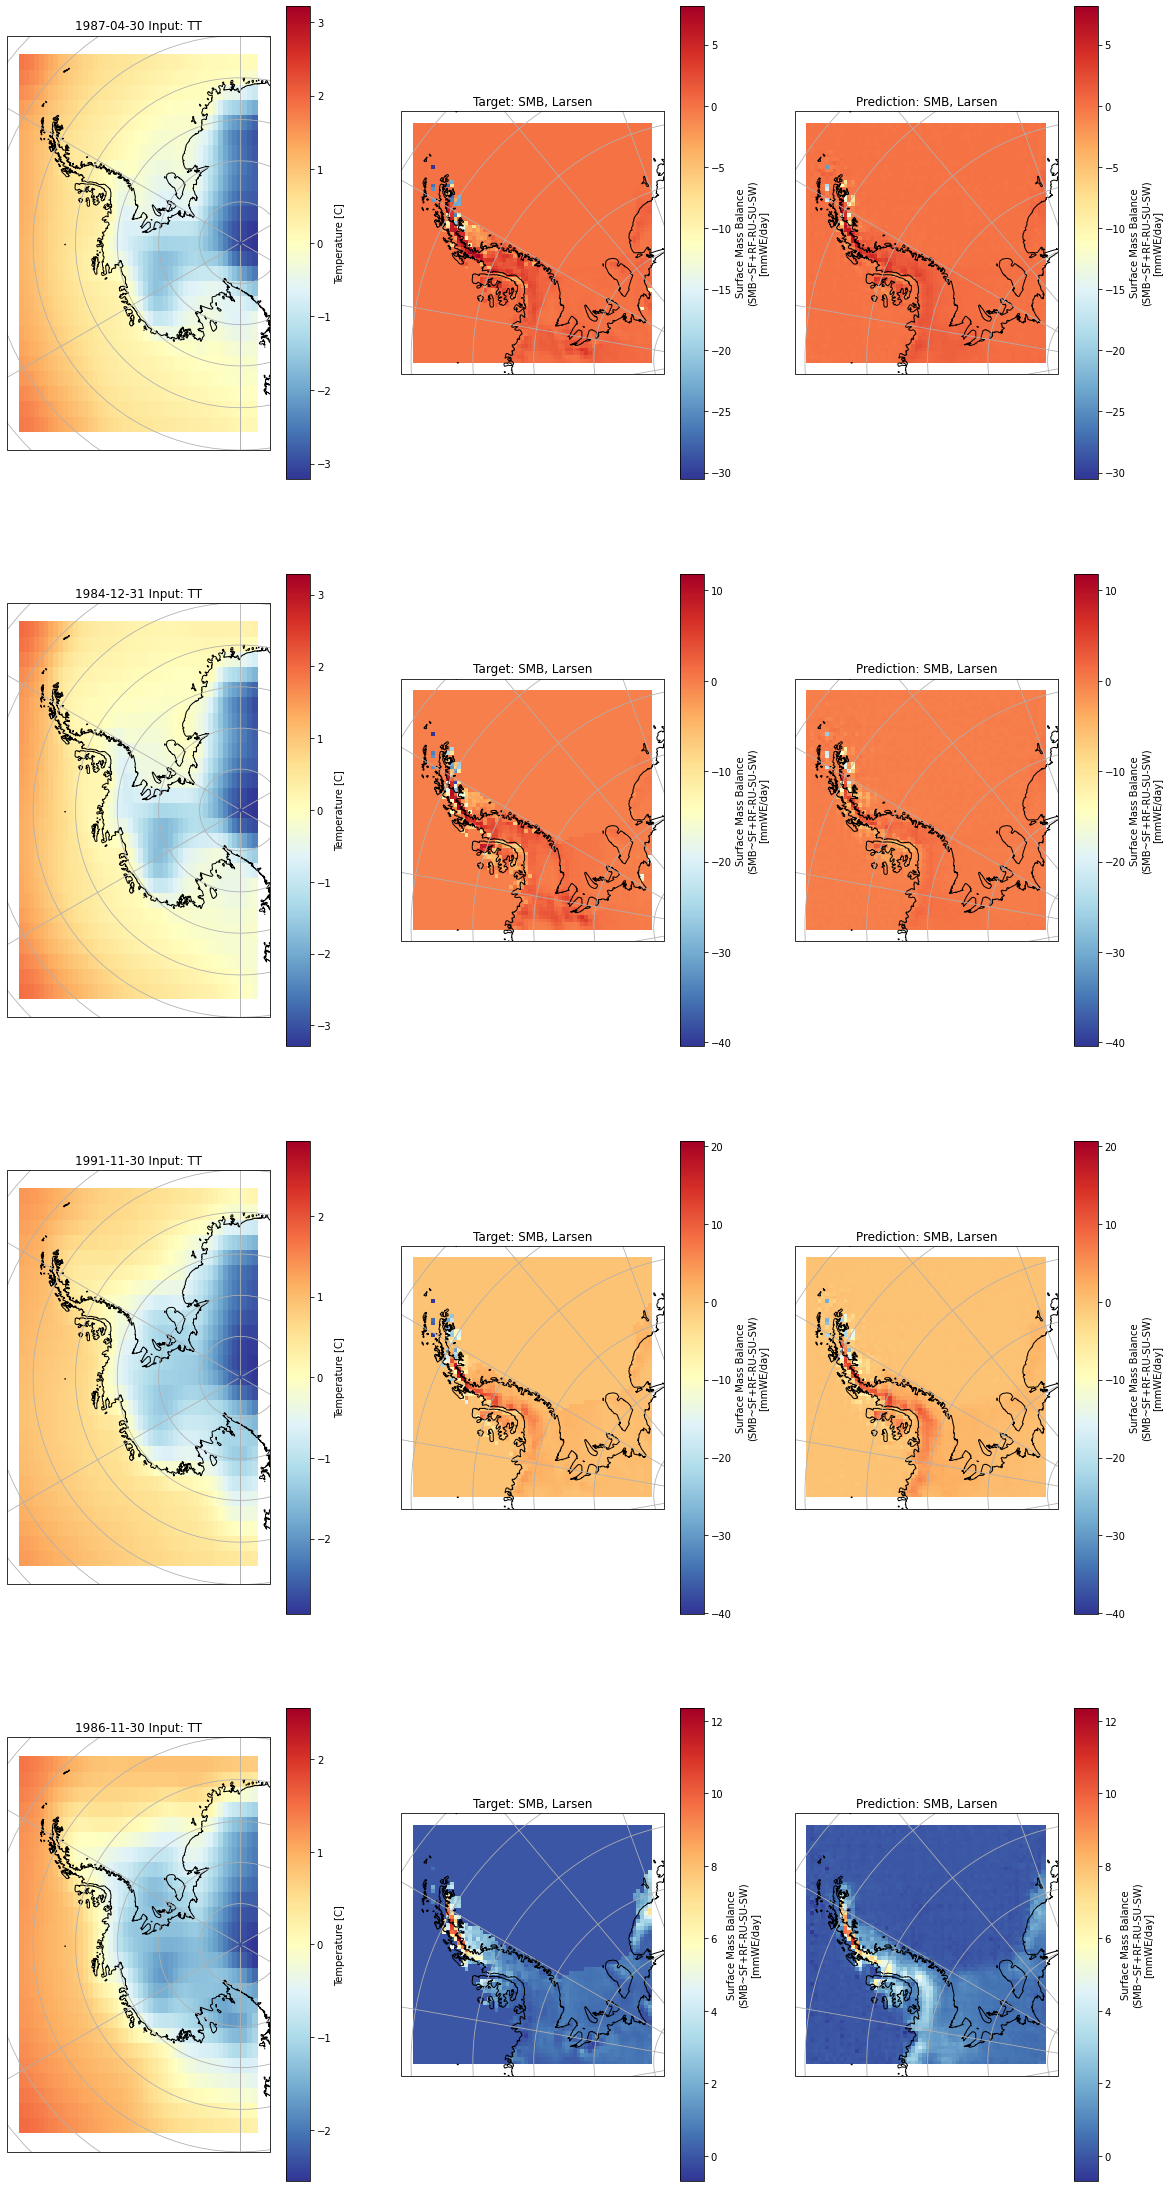

In [173]:
# plot predictions
f = plt.figure(figsize=(20, 40))

plotRandomPredictions(
    preds_Larsen,
    x_Larsen,
    z_Larsen,
    true_smb_Larsen,
    r_Larsen,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION]
)
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

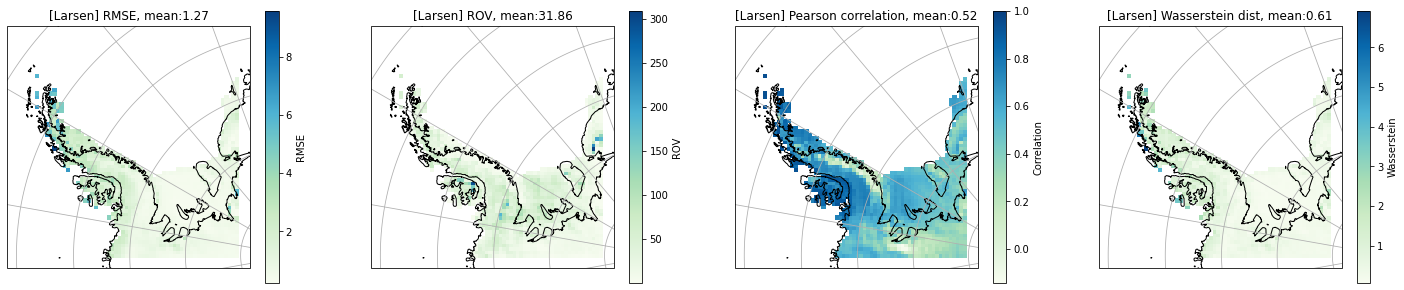

In [174]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Larsen, true_smb_Larsen, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)


### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


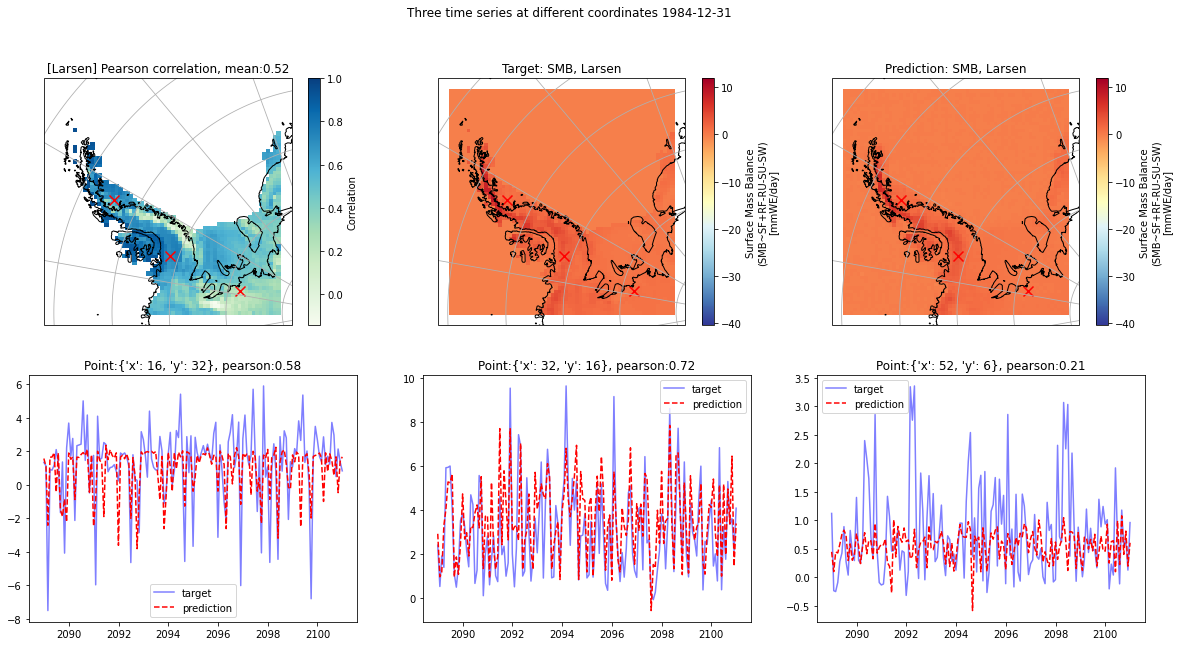

In [175]:
# plot points
points= ({'x':16, 'y':32},{'x':32, 'y':16}, {'x':52, 'y':6})
randomPoints(points, PearsonCorr, true_smb_Larsen, preds_Larsen, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Maud:

In [176]:
REGION = "Maud"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
#today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Maud, x_Maud, z_Maud, true_smb_Maud, r_Maud = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-05_Maud_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

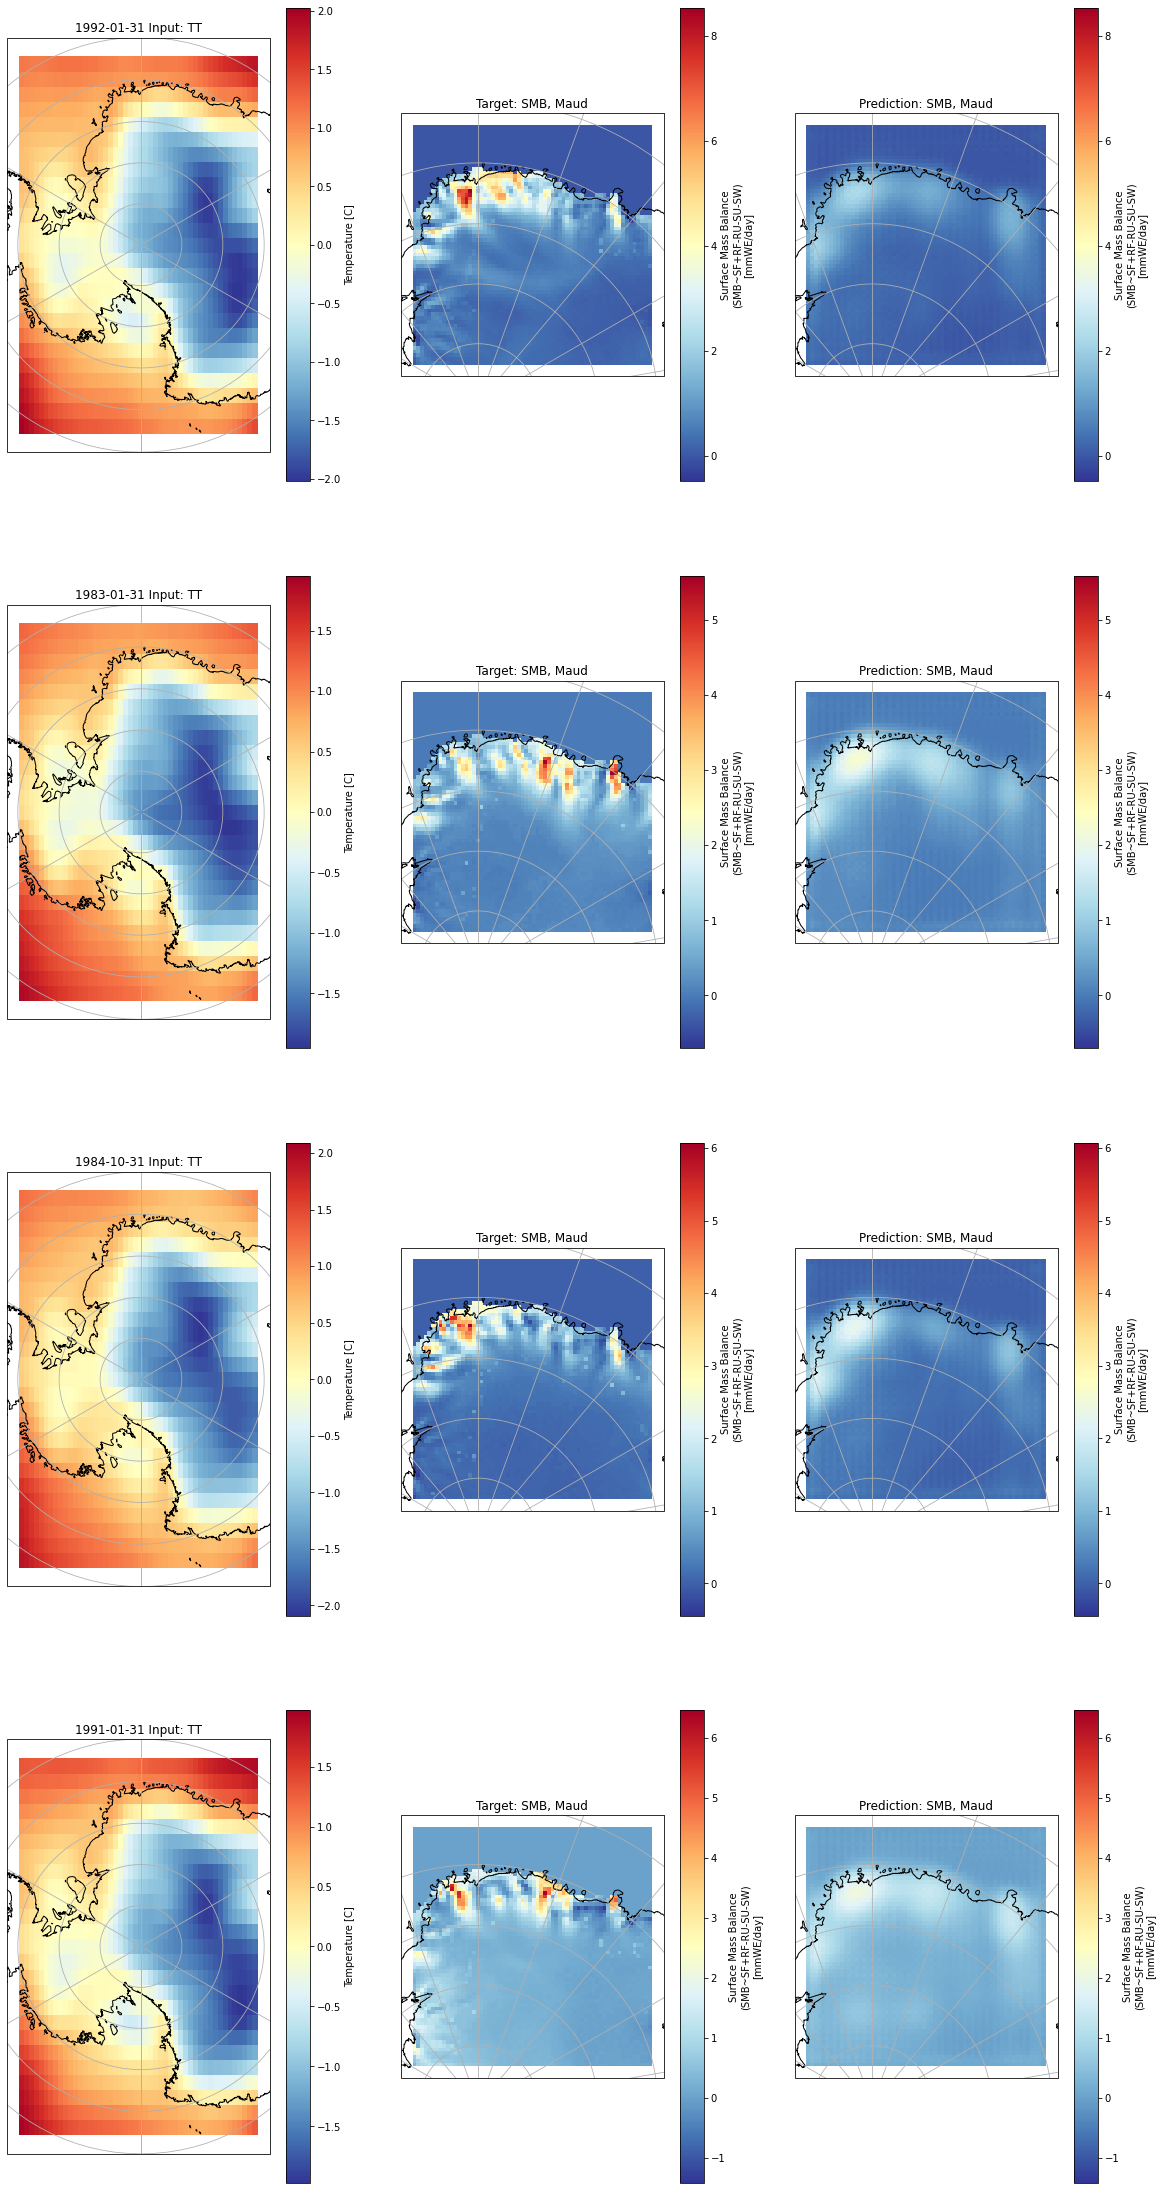

In [177]:
# plot predictions
f = plt.figure(figsize=(20, 40))

plotRandomPredictions(
    preds_Maud,
    x_Maud,
    z_Maud,
    true_smb_Maud,
    r_Maud,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION]
)
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

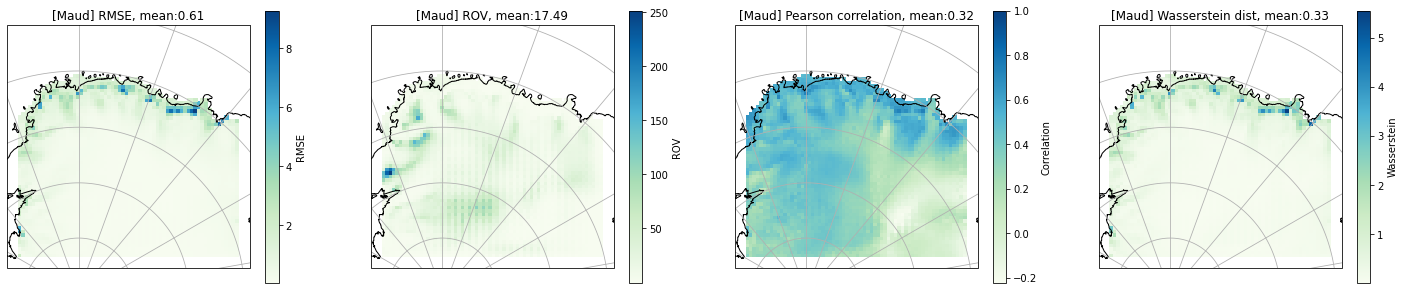

In [178]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Maud, true_smb_Maud, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)


### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


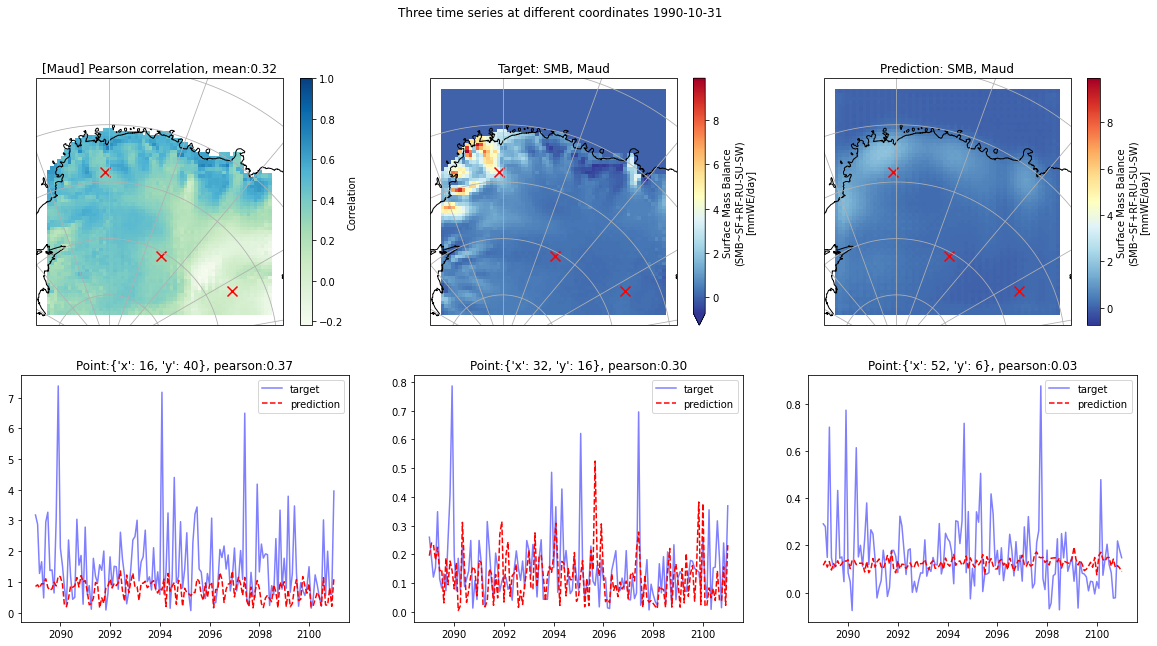

In [179]:
# plot points
points= ({'x':16, 'y':40},{'x':32, 'y':16}, {'x':52, 'y':6})
randomPoints(points, PearsonCorr, true_smb_Maud, preds_Maud, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Wilkes:

In [180]:
REGION = "Wilkes"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
#today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Wilkes, x_Wilkes, z_Wilkes, true_smb_Wilkes, r_Wilkes = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-05_Wilkes_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

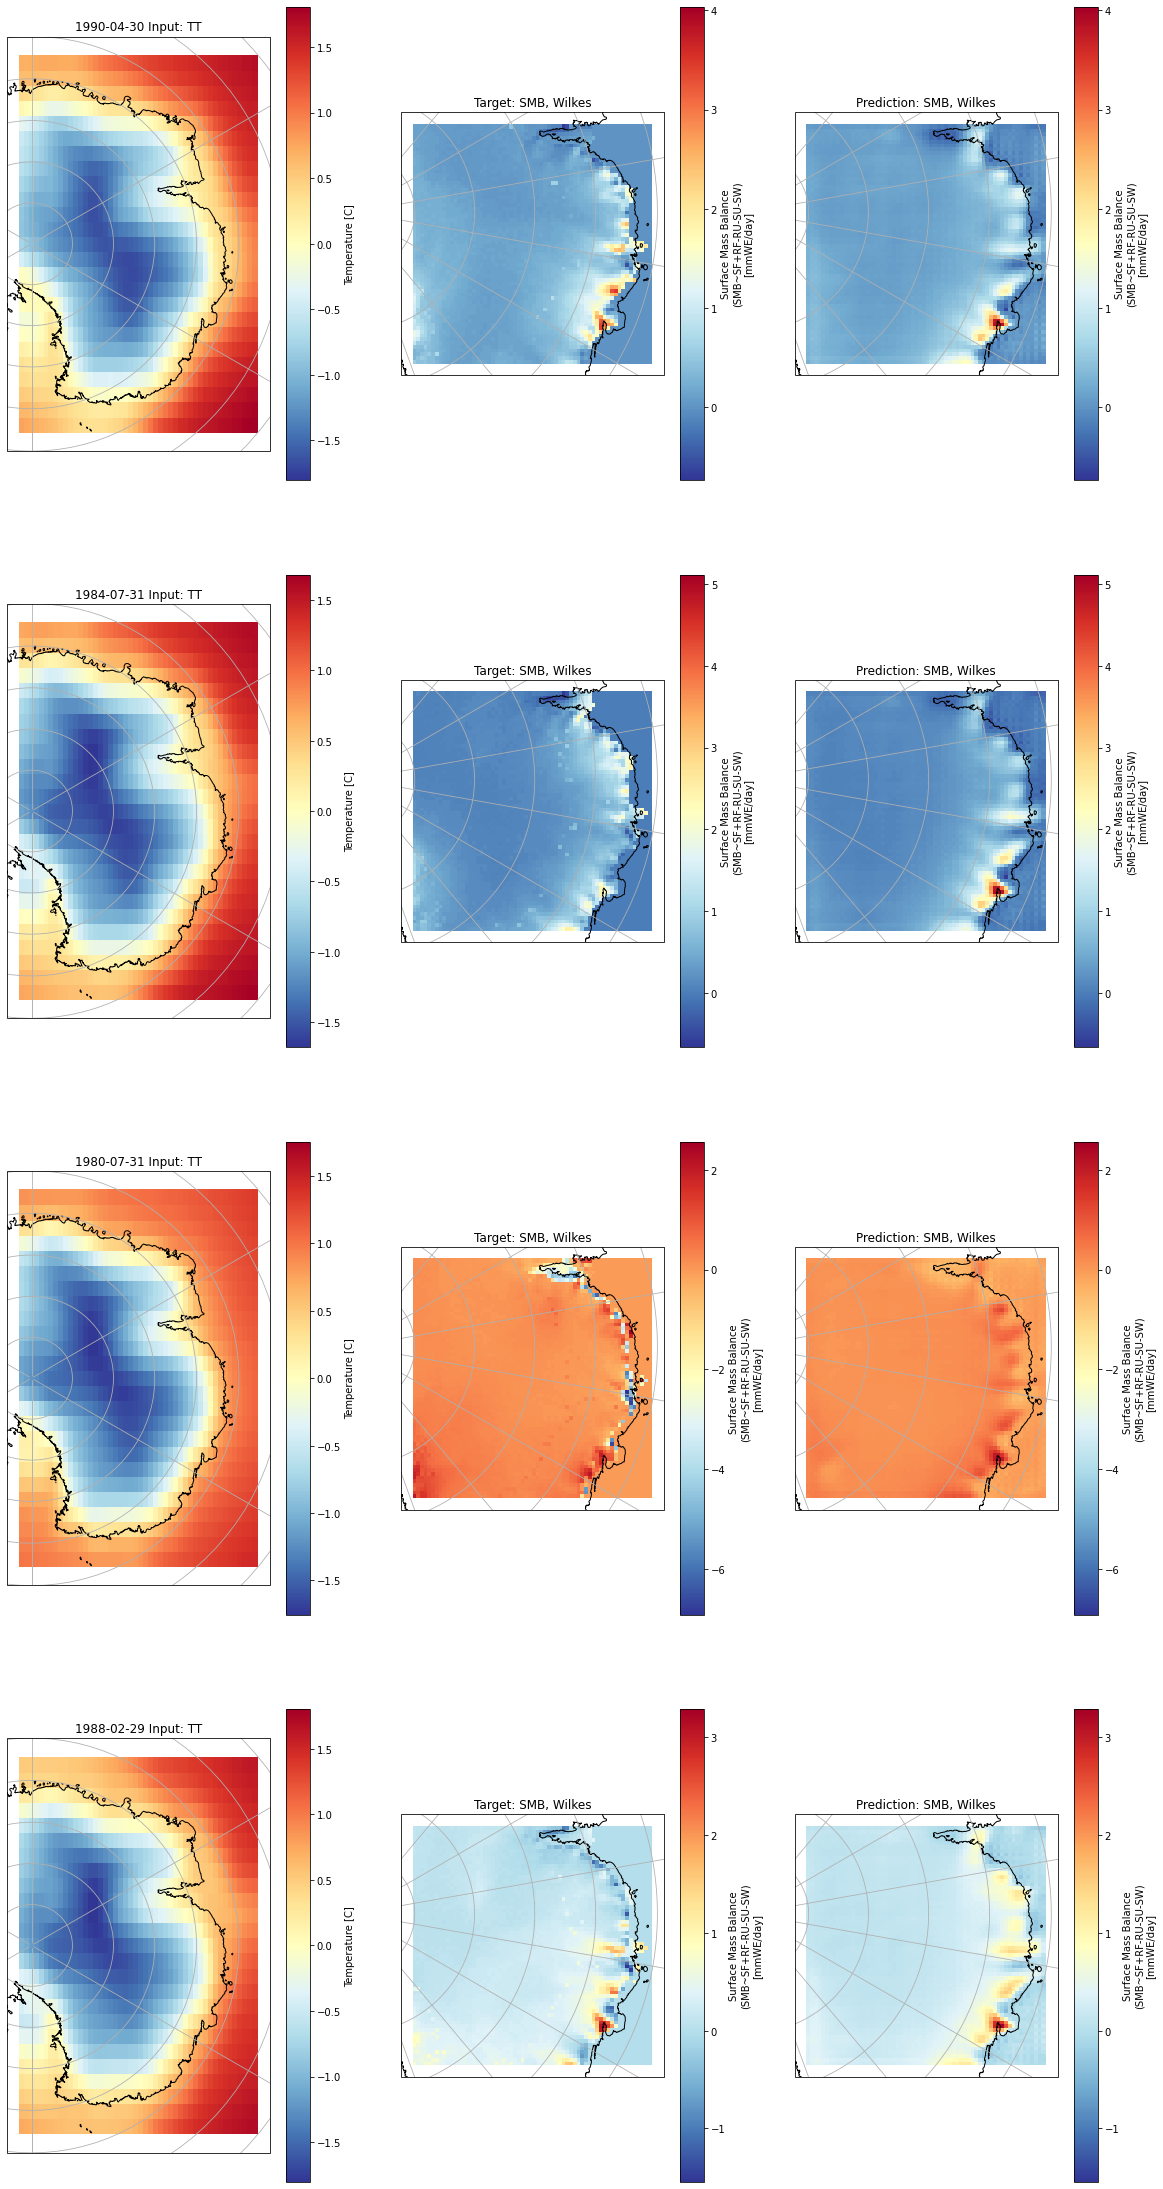

In [181]:
# plot predictions
f = plt.figure(figsize=(20, 40))
plotRandomPredictions(
    preds_Wilkes,
    x_Wilkes,
    z_Wilkes,
    true_smb_Wilkes,
    r_Wilkes,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION]
)
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

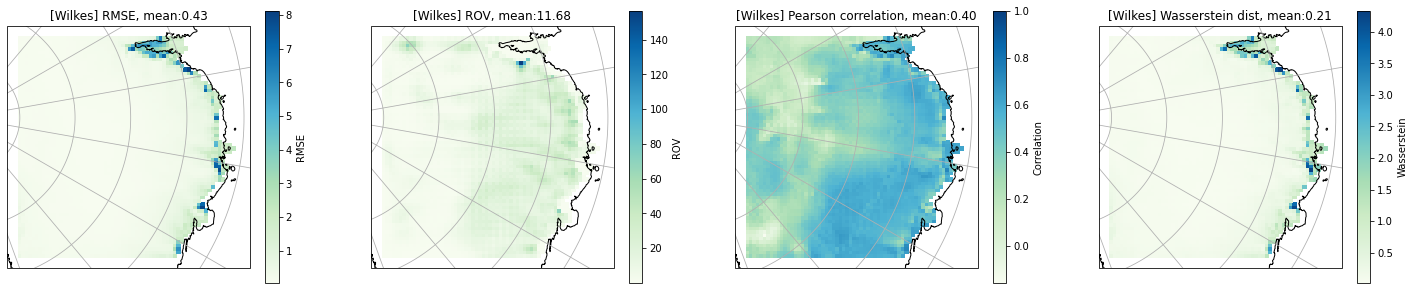

In [182]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Wilkes, true_smb_Wilkes, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


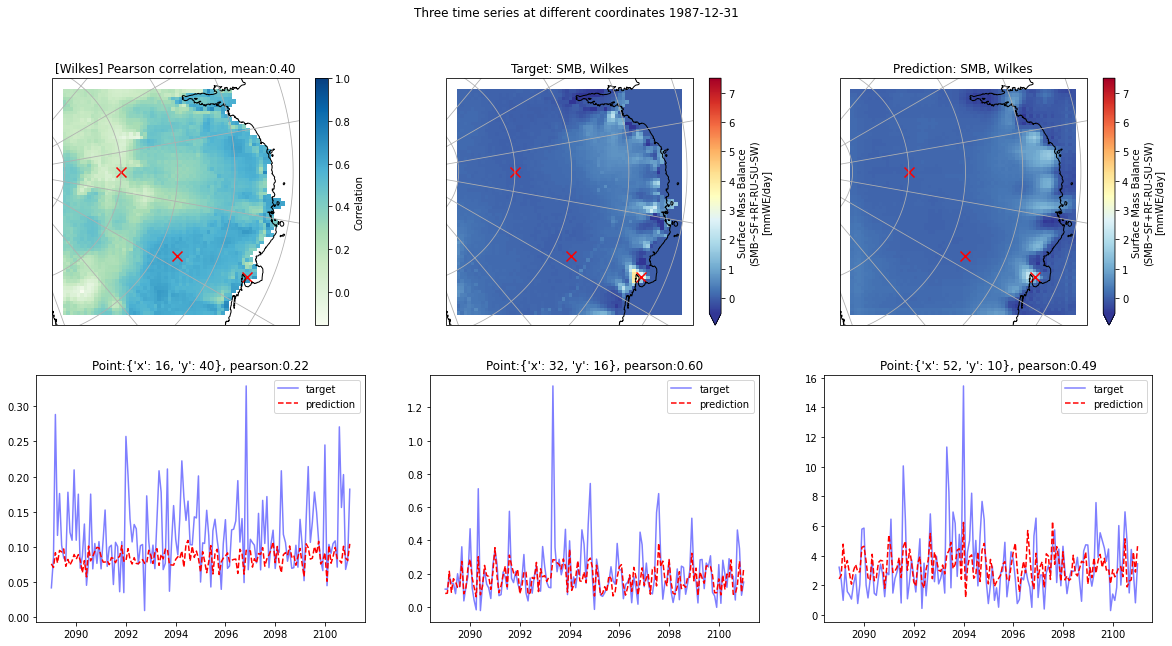

In [183]:
# plot points
points= ({'x':16, 'y':40},{'x':32, 'y':16}, {'x':52, 'y':10})
randomPoints(points, PearsonCorr, true_smb_Wilkes, preds_Wilkes, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Amundsen:

In [184]:
REGION = "Amundsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
#today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Am, x_Am, z_Am, true_smb_Am, r_Am = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-05_Amundsen_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

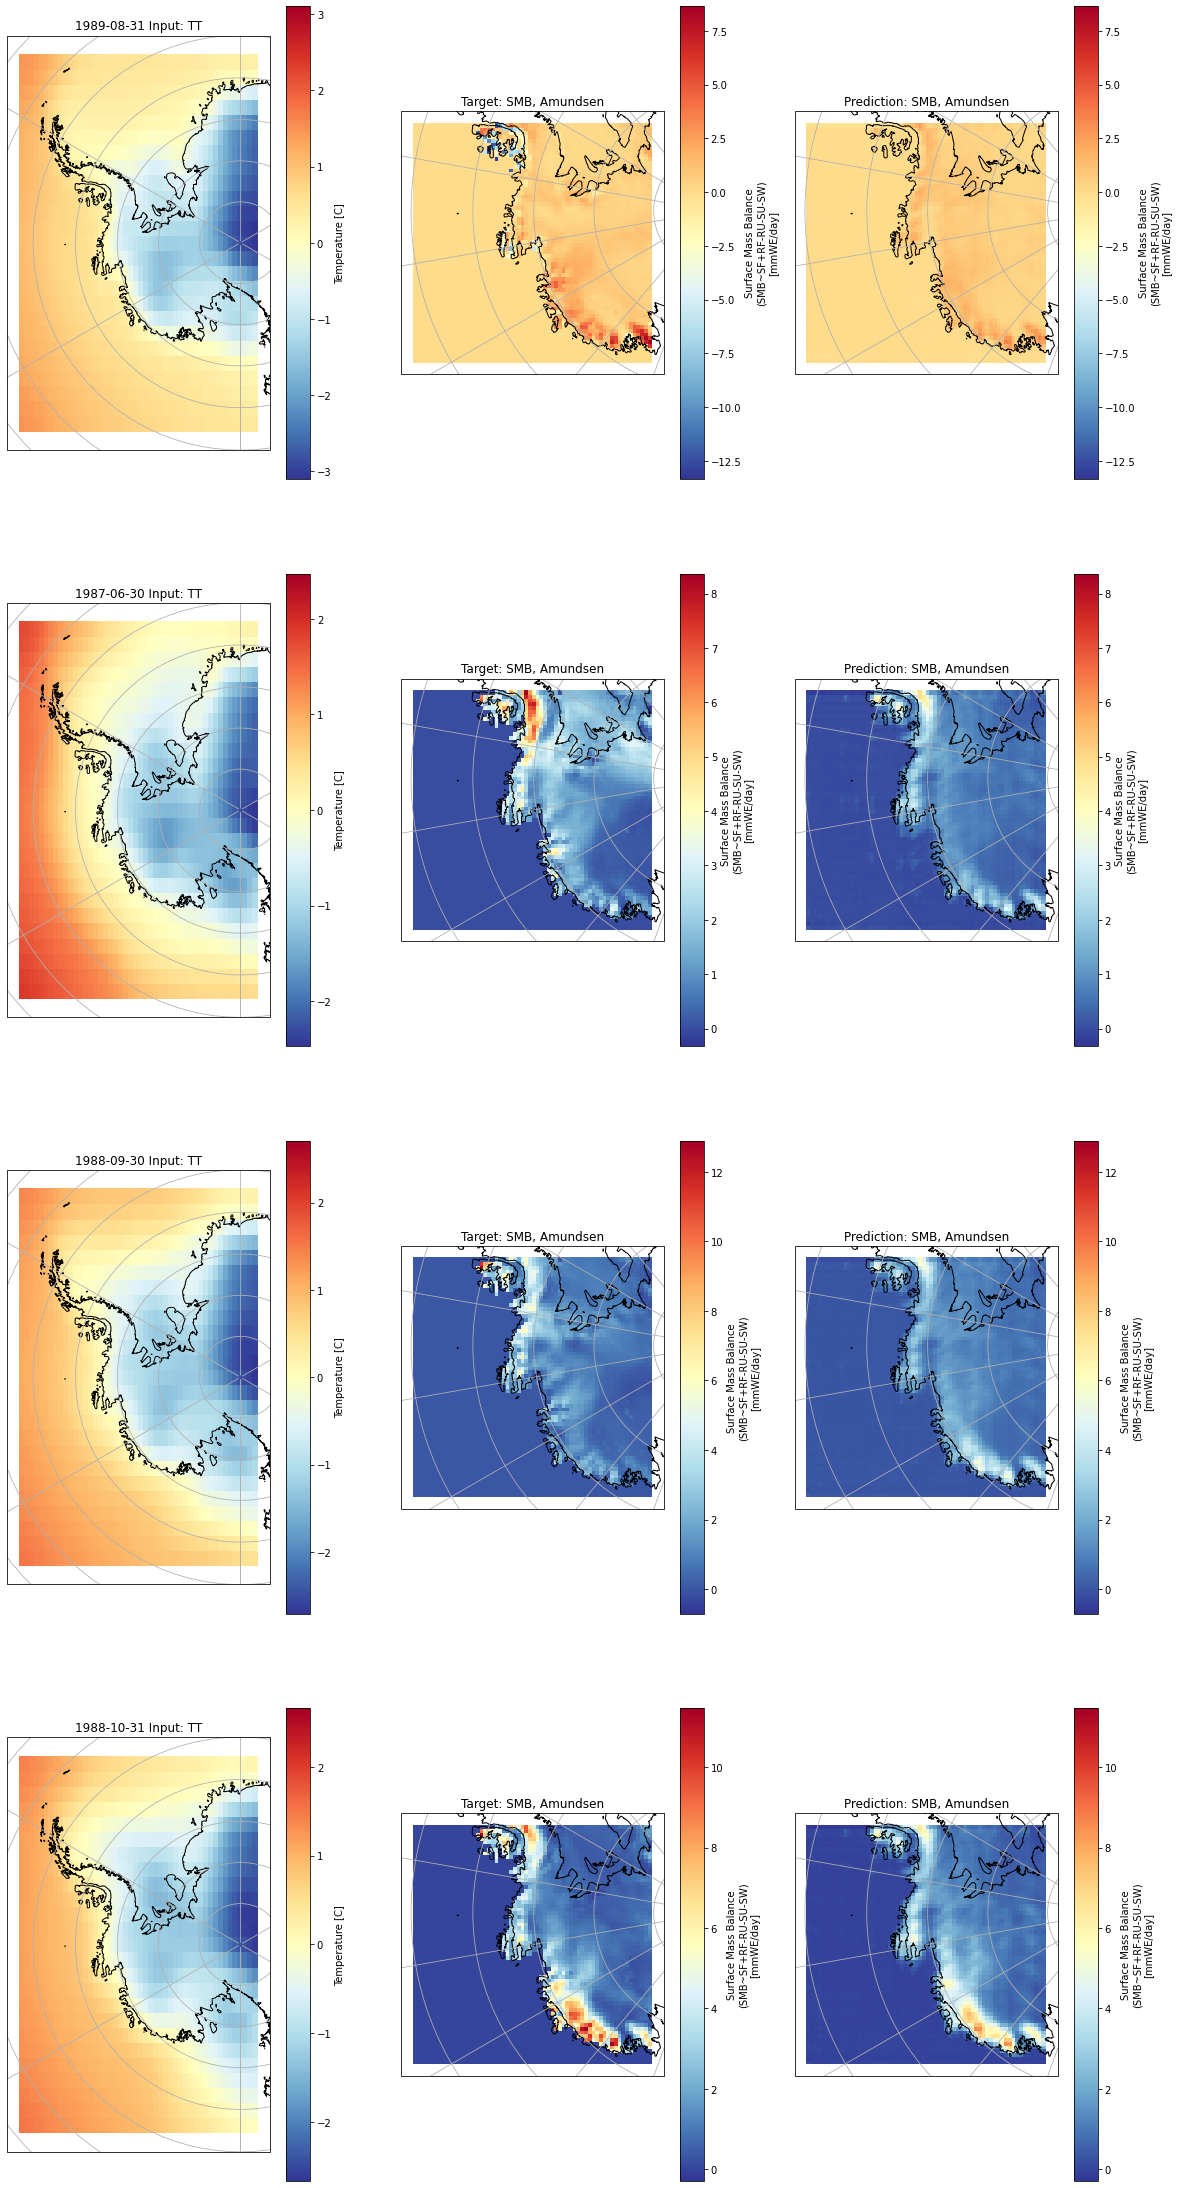

In [185]:
# plot predictions
f = plt.figure(figsize=(20, 40))
plotRandomPredictions(
    preds_Am,
    x_Am,
    z_Am,
    true_smb_Am,
    r_Am,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION])
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

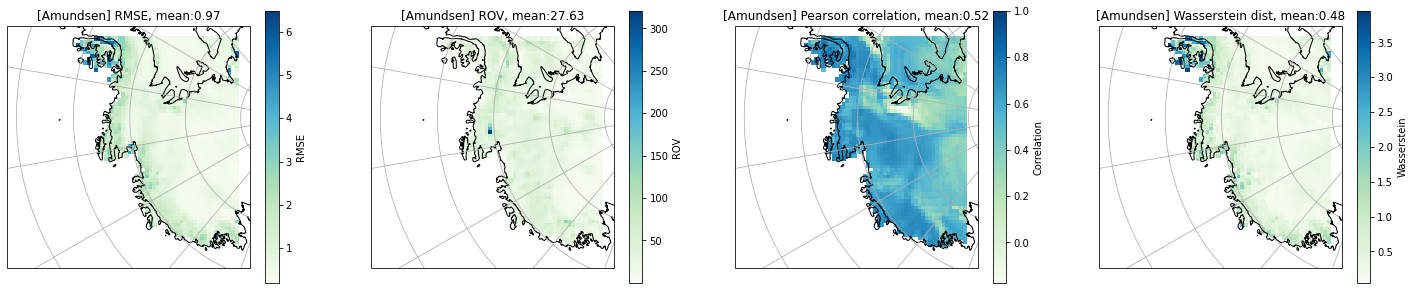

In [186]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Am, true_smb_Am, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


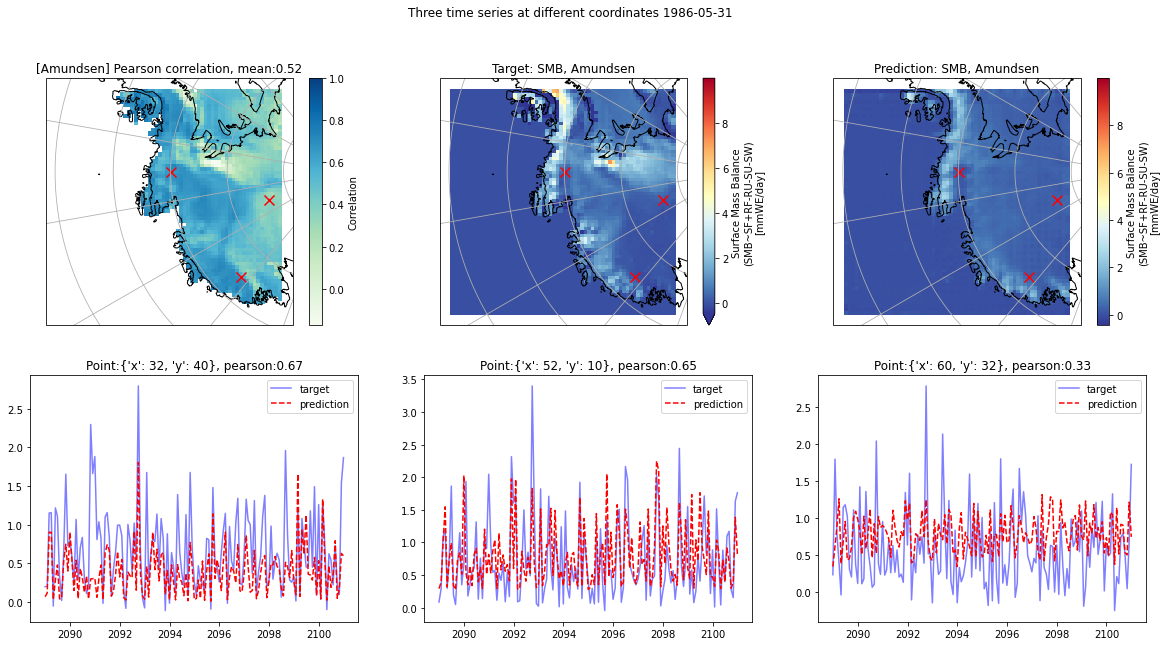

In [196]:
# plot points
points= ({'x':32, 'y':40}, {'x':52, 'y':10},{'x':60, 'y':32})
randomPoints(points, PearsonCorr, true_smb_Am, preds_Am, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Evaluation table:

In [188]:
PearsonCorr_Am, Wasserstein_Am, ROV_Am, RMSE_Am = calculateMetrics(
    preds_Am, true_smb_Am, ignoreSea
)
PearsonCorr_Wilkes, Wasserstein_Wilkes, ROV_Wilkes, RMSE_Wilkes = calculateMetrics(
    preds_Wilkes, true_smb_Wilkes, ignoreSea
)
PearsonCorr_Larsen, Wasserstein_Larsen, ROV_Larsen, RMSE_Larsen = calculateMetrics(
    preds_Larsen, true_smb_Larsen, ignoreSea
)
PearsonCorr_Maud, Wasserstein_Maud, ROV_Maud, RMSE_Maud = calculateMetrics(
    preds_Maud, true_smb_Maud, ignoreSea
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: 

In [189]:
l = [
    metricsData(Wasserstein_Larsen),
    metricsData(RMSE_Larsen),
    metricsData(ROV_Larsen),
    metricsData(PearsonCorr_Larsen),
]
df_Larsen = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Larsen["Region"] = ["Larsen" for i in range(len(df_Larsen))]
df_Larsen = df_Larsen.reset_index()

In [190]:
l = [
    metricsData(Wasserstein_Wilkes),
    metricsData(RMSE_Wilkes),
    metricsData(ROV_Wilkes),
    metricsData(PearsonCorr_Wilkes),
]
df_Wilkes = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Wilkes["Region"] = ["Wilkes" for i in range(len(df_Wilkes))]
df_Wilkes = df_Wilkes.reset_index()

In [191]:
l = [
    metricsData(Wasserstein_Am),
    metricsData(RMSE_Am),
    metricsData(ROV_Am),
    metricsData(PearsonCorr_Am),
]
df_Am = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Am["Region"] = ["Amundsen" for i in range(len(df_Am))]
df_Am = df_Am.reset_index()

In [192]:
l = [
    metricsData(Wasserstein_Maud),
    metricsData(RMSE_Maud),
    metricsData(ROV_Maud),
    metricsData(PearsonCorr_Maud),
]
df_Maud = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Maud["Region"] = ["Maud" for i in range(len(df_Maud))]
df_Maud = df_Maud.reset_index()


In [193]:
pd.concat([df_Larsen, df_Maud, df_Am, df_Wilkes]).groupby(['Region', 'index']).mean()

min       p05       mean     median        p95  \
Region   index                                                              
Amundsen Pearson     -0.174087  0.260077   0.524042   0.545097   0.718684   
         RMSE         0.195216  0.319539   0.974959   0.625211   2.556459   
         ROV          0.002387  2.630297  27.632699  25.172856  63.133908   
         Wasserstein  0.049264  0.126769   0.481016   0.295989   1.448269   
Larsen   Pearson     -0.142526  0.180988   0.515678   0.512267   0.871738   
         RMSE         0.228058  0.340361   1.270851   0.773676   3.590253   
         ROV          0.052537  2.696823  31.862907  24.483283  80.182370   
         Wasserstein  0.065383  0.117606   0.608091   0.383565   1.752375   
Maud     Pearson     -0.221234 -0.055811   0.316958   0.358624   0.568863   
         RMSE         0.062152  0.112056   0.610181   0.269024   2.266651   
         ROV          0.003465  0.677945  17.492837  10.937169  59.527227   
         Wasserstein  0.012832  0.041523   0.330670   0.133267   1.274198   
Wilkes   Pearson     -0.156507  0.132004   0.400532   0.418424   0.603799   
         RMSE         0.048040  0.067522   0.427413   0.162387   1.805201   
         ROV          0.005087  0.624443  11.683167   8.244621  31.526649   
         Wasserstein  0.021729  0.036911   0.210404   0.087119   0.863827   

                             max  
Region   index                    
Amundsen Pearson        0.838787  
         RMSE           6.480841  
         ROV          320.479465  
         Wasserstein    3.949453  
Larsen   Pearson        0.950041  
         RMSE           9.579792  
         ROV          308.775353  
         Wasserstein    6.915613  
Maud     Pearson        0.736627  
         RMSE           9.263544  
         ROV          251.229715  
         Wasserstein    5.553235  
Wilkes   Pearson        0.730574  
         RMSE           8.124560  
         ROV          156.431282  
         Wasserstein    4.330479

In [ ]:
# temporal corerlation:
def calculatePearson(preds, true_smb, ignoreSea=True):
    predictions = torch.tensor(preds)
    target = torch.tensor(true_smb)

    PearsonCorr = np.empty((predictions.shape[1], predictions.shape[2], 1))
    for i in range(predictions.shape[1]):  # x
        for j in range(predictions.shape[2]):  # y
            pixelPred = predictions[:, i, j, 0].numpy()
            pixelTarg = target[:, i, j, 0].numpy()
            PearsonCorr[i, j] = np.corrcoef(pixelPred, pixelTarg)[0, 1]

    if ignoreSea:
        return PearsonCorr
    else:
        # Fill NaN with 0 (uncorrelated)
        PearsonCorr = np.nan_to_num(PearsonCorr)
        return PearsonCorr